## Model Building

Since the outcome variable is categorical Logistic or Tree based models can be used for prediction.

In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, classification_report

In [3]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [9]:
df = df.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

### 1. Logistic Regression

Model assumptions :

1. Outcome variable is categorical
2. Observations are independent of each other
3. No severe multicollinearity among X variables
4. No extreme outliers
5. Linear relationship between each X variable and the logit of the outcome variable
6. Sufficiently large sample size

In [10]:
# we have 2 object variables of which department is categorical and salary is categorical but ordinal

df_enc= df.copy()

df_enc['salary'] = df_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes

df_enc = pd.get_dummies(df_enc, drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False



This code snippet is converting the salary column in the df_enc DataFrame from a string or object type into a numerical format by following these steps:

1. astype('category'): The salary column is first converted into a categorical data type. This tells pandas that the column should be treated as containing distinct categories (rather than raw text).
2. .cat.set_categories(['low', 'medium', 'high']): This specifies the explicit order of categories for the salary column. The categories are ordered as ['low', 'medium', 'high'], which is useful when you want to assign an ordinal relationship between the categories.
3. .cat.codes: After setting the categories, cat.codes converts the categorical values into their respective integer codes. In this case:
'low' is encoded as 0,
'medium' is encoded as 1,
'high' is encoded as 2

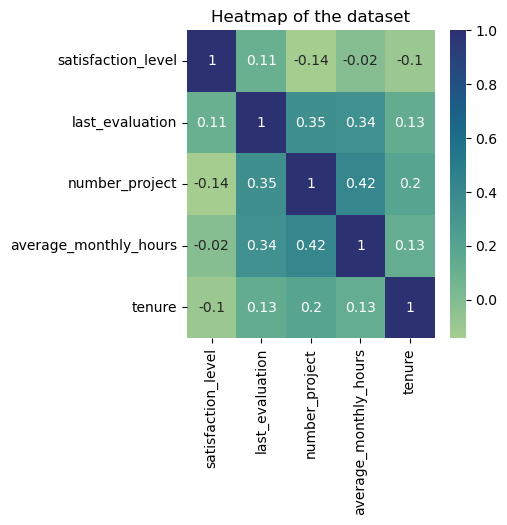

In [13]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(4, 4))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

In [15]:
## as we have observed outliers in tenure in EDA lets remove them as logistic regression is sensitve to outliers
# Define the upper limit and lower limit for non-outlier values in `tenure`
iqr = df_enc['tenure'].quantile(0.75) - df_enc['tenure'].quantile(0.25)
upper_limit = df_enc['tenure'].quantile(0.75) + 1.5 * iqr
lower_limit = df_enc['tenure'].quantile(0.25) - 1.5 * iqr

df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

In [28]:
df['left'].value_counts(normalize=True) # the data is not highly imbalanced

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

In [17]:
# Preparing data for modeling

y = df_logreg['left']
X = df_logreg.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

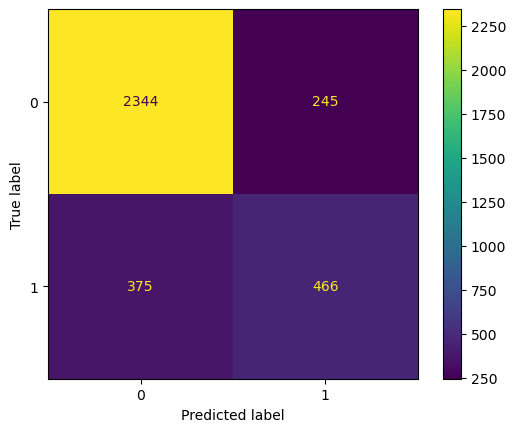

In [22]:
# Fitting the model

log_clf = LogisticRegression(random_state=42,max_iter=500).fit(X_train,y_train)
y_pred = log_clf.predict(X_test)

log_cm = confusion_matrix(y_test,y_pred,labels=log_clf.classes_)

log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,display_labels=log_clf.classes_)
log_disp.plot(values_format='')

plt.show()

The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [32]:
targets =['predicted would not leave','predicted will leave'] # naming for better readability of report
print(classification_report(y_test,y_pred,target_names=targets))

                           precision    recall  f1-score   support

predicted would not leave       0.86      0.91      0.88      2589
     predicted will leave       0.66      0.55      0.60       841

                 accuracy                           0.82      3430
                macro avg       0.76      0.73      0.74      3430
             weighted avg       0.81      0.82      0.81      3430



The classification report above shows that the logistic regression model achieved a precision of 81%, recall of 82%, f1-score of 81% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

### Tree-based Model¶

In [ ]:
# as tree based models are not effected by outliers we dont need to remove the outliers in tenure use df_enc
y = df_enc['left']
X = df_enc.drop('left', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)